In [1]:
import sys
import os

# Voeg het pad toe aan sys.path
module_path = os.path.abspath(r'C:\Users\luukwouterse\Downloads\CapstoneAI-FiberProbe-main')  # of een specifiek pad zoals: '/mnt/data'
if module_path not in sys.path:
    sys.path.append(module_path)

In [35]:
### Start user input ###
path_to_data = r'U:\Bubble Column\Data\2411_Xray alcohols\Fiber Probe\241108 - Water center of column' 
path_to_output = r'H:\My Documents\Capstone results'
### End user input ###

# Libary imports
import pandas as pd
import torch
import numpy as np
import pickle

# Function imports
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data
from models import load_scalers, LSTMModel, GRUModel

gru1 = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru1.load_state_dict(torch.load(path_to_output+"/models/gru20-5_2-20%3_is1_ns20_nl2_lr0.005_ep5000_r20.993", map_location='cpu'))
gru1.eval()

gru2 = GRUModel(input_size=1, hidden_size=25, num_layers=2)
gru2.load_state_dict(torch.load(path_to_output+"/models/gru20-5_2-20%3_is1_ns25_nl2_lr0.002_ep6000_r20.970", map_location='cpu'))
gru2.eval()

lstm = LSTMModel(input_size=1, hidden_size=18, num_layers=2)
lstm.load_state_dict(torch.load(path_to_output+"/models/lstm19-5_2-20%3_is1_ns18_nl2_lr0.01_ep40000_r20.97-", map_location='cpu'))
lstm.eval()

with open(path_to_output+'/scalers/feature_scaler2-20%3.pkl', 'rb') as f:
    feature_scaler = pickle.load(f)

with open(path_to_output+'/scalers/target_scaler2-20%3.pkl', 'rb') as f:
    target_scaler = pickle.load(f)


In [28]:
df = process_folder(path_to_data, path_to_output, files=[3,7,12,18], plot=False, labels=True,)

Binlog data extracted
Processing run: 2024-11-08T145406
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 40, 'bin_file': '2024-11-08T145406.bin'}
836458000 datapoints extracted
LABELS: 586 bubble labels with VeloOut != -1 extracted.
No missing labels.
EXTRACTED: 586 bubbles have VeloOut != -1 out of 1736 total bubbles.
            bubble_idx E_idx L_idx   VeloOut  \
0  0_2024-11-08T145406    E0    -1 -1.000000   
1  1_2024-11-08T145406    E1    -1 -1.000000   
2  2_2024-11-08T145406    E2    L0  0.683543   
3  3_2024-11-08T145406    E3    -1 -1.000000   
4  4_2024-11-08T145406    E4    -1 -1.000000   

                                          VoltageOut  FlowRate     Frequency  
0  [0.5689260363578796, 0.5583666563034058, 0.580...        40  2.083333e+07  
1  [0.5678884387016296, 0.5625782012939453, 0.571...        40  2.083333e+07  
2  [0.6280099153518677, 0.6185491681098938, 0.634...        40  2.083333e+07  
3  [0.

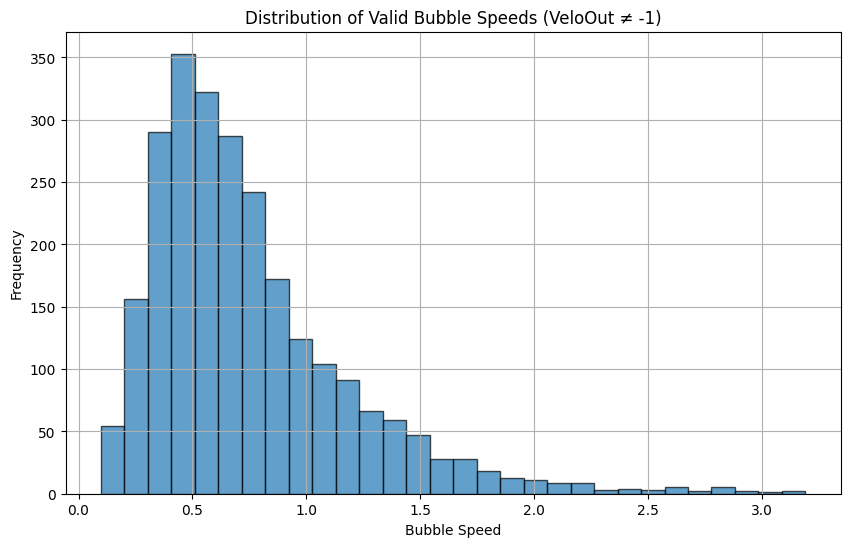

In [36]:
import matplotlib.pyplot as plt

# Filter out invalid speeds
valid_speeds = df[df["VeloOut"] != -1]["VeloOut"]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(valid_speeds, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Valid Bubble Speeds (VeloOut ≠ -1)")
plt.xlabel("Bubble Speed")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [52]:
X_array = np.vstack(df["VoltageOut"].to_numpy())  # shape: (samples, timesteps)
X_scaled = feature_scaler.transform(X_array)      # apply your trained scaler
X_tensor = torch.tensor(X_scaled[..., np.newaxis], dtype=torch.float32)  # shape: (samples, timesteps, 1)

with torch.no_grad():  
        y_gru1_scaled = gru1(X_tensor)
        y_gru2_scaled = gru2(X_tensor)
        y_lstm_scaled = lstm(X_tensor)
y_gru1 = target_scaler.inverse_transform(y_gru1_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2 = target_scaler.inverse_transform(y_gru2_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm = target_scaler.inverse_transform(y_lstm_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()

y_pred = ((y_lstm+y_gru1+y_gru2)/3).flatten()
outcome_df = pd.DataFrame({"predictions model 1": y_gru1, "predictions model 2": y_gru2, "predictions model 3": y_lstm, "final prediction": y_pred})
outcome_df['Standard deviation'] = outcome_df[["predictions model 1", "predictions model 2", "predictions model 3"]].std(axis=1)
outcome_df['Standard deviation %'] = outcome_df['Standard deviation'] / outcome_df['final prediction'] * 100

print(outcome_df.head(10))

# Evaluation metrics (remove '''...''' if interested)
valid_bubbles_ai = len(outcome_df[outcome_df['Standard deviation %'] < 10])/len(outcome_df) * 100
valid_bubbles_boring_software = len(valid_velo_data(df)[0])/len(df) * 100

X_velo, y_velo = valid_velo_data(df)
X_velo_scaled = torch.tensor(feature_scaler.transform(X_velo)[...,np.newaxis], dtype=torch.float32)
with torch.no_grad():  
        y_gru1_scaled_velo = gru1(X_velo_scaled)
        y_gru2_scaled_velo = gru2(X_velo_scaled)
        y_lstm_scaled_velo = lstm(X_velo_scaled)
y_gru1_velo = target_scaler.inverse_transform(y_gru1_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2_velo = target_scaler.inverse_transform(y_gru2_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm_velo = target_scaler.inverse_transform(y_lstm_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_pred_velo = ((y_lstm_velo+y_gru1_velo+y_gru2_velo)/3).flatten()
outcome_df_valid = pd.DataFrame({"predictions model 1": y_gru1_velo, "predictions model 2": y_gru2_velo, "predictions model 3": y_lstm_velo, "final prediction": y_pred_velo})
outcome_df_valid['Standard deviation'] = outcome_df_valid[["predictions model 1", "predictions model 2", "predictions model 3"]].std(axis=1)
outcome_df_valid['Standard deviation %'] = outcome_df_valid['Standard deviation'] / outcome_df_valid['final prediction'] * 100
valid_test_results = outcome_df_valid[(outcome_df_valid["Standard deviation"]/outcome_df_valid["final prediction"]) <= 0.1]

filtered_outcome_df = outcome_df_valid[outcome_df_valid['Standard deviation %'] < 10]
average_percentage_std = filtered_outcome_df['Standard deviation %'].mean()

print(f"Percentage found valid bubbles (uncertainty < 10%) with speed difference <10% from truth:  {len(valid_test_results) / (len(outcome_df_valid)) * 100:.4f} %")
print(f'Percentage AI found valid bubbles (uncertainty < 10%): {valid_bubbles_ai:.4f} % vs M2 analyzer: {valid_bubbles_boring_software:.4f} %, improvement: {((valid_bubbles_ai - valid_bubbles_boring_software)/valid_bubbles_boring_software)*100:.4f} %')
print(f'Model uncertainty (average uncertainty of valid bubbles): {average_percentage_std:.4f} % with {len(filtered_outcome_df) / len(outcome_df_valid) * 100:.2f} % of the labled samples')


   predictions model 1  predictions model 2  predictions model 3  \
0             4.057274             2.014147             0.474124   
1             0.680125             0.491285             0.642780   
2             0.673761             0.672278             0.684362   
3             1.903904             1.707966             1.106697   
4             1.034001             1.068300             1.212294   
5             1.970096             1.364549             2.270492   
6             0.340412             0.335398             0.383188   
7             0.828006             0.817311             0.819581   
8             0.843979             0.859413             0.849731   
9             0.762812             0.772330             0.783455   

   final prediction  Standard deviation  Standard deviation %  
0          2.181849            1.797452             82.382088  
1          0.604730            0.100005             16.537088  
2          0.676800            0.006590              0.9737

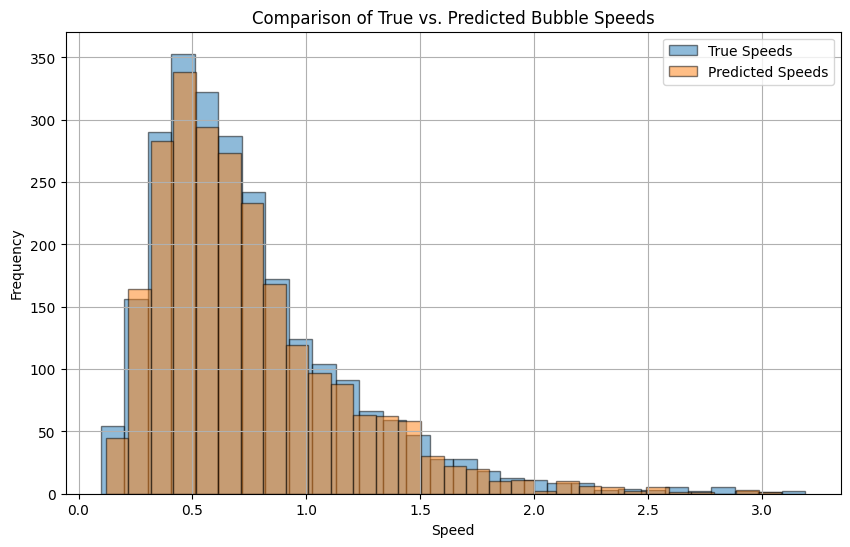

In [60]:
valid_df = df[df["VeloOut"] != -1]


# Match index if necessary
true_speeds = valid_df["VeloOut"]
predicted_valid_speeds = valid_test_results["final prediction"]
# Plot
plt.figure(figsize=(10, 6))
plt.hist(true_speeds, bins=30, alpha=0.5, label="True Speeds", edgecolor='black')
plt.hist(predicted_valid_speeds, bins=30, alpha=0.5, label="Predicted Speeds", edgecolor='black')
plt.title("Comparison of True vs. Predicted Valid Bubble Speeds")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

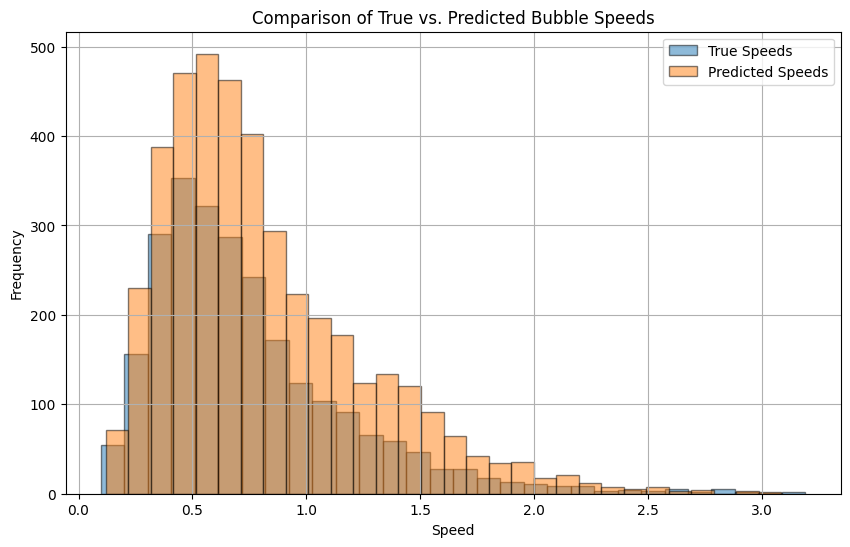

In [56]:
valid_df = df[df["VeloOut"] != -1]
cert_outcome_df = outcome_df[outcome_df['Standard deviation %'] < 10]

# Match index if necessary
true_speeds = valid_df["VeloOut"]
predicted_valid_speeds = filtered_outcome_df["final prediction"]
predicted_speeds = cert_outcome_df["final prediction"]
# Plot
plt.figure(figsize=(10, 6))
plt.hist(true_speeds, bins=30, alpha=0.5, label="True Speeds", edgecolor='black')
plt.hist(predicted_speeds, bins=30, alpha=0.5, label="Predicted Speeds", edgecolor='black')
plt.title("Comparison of True vs. Predicted Bubble Speeds")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [57]:
predicted_speeds.shape

(4137,)

In [58]:
valid_df.shape

(2510, 7)